In [1]:
# default_exp gan.learner

# gan.learner

> API details.

In [2]:
# export

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from fastrenewables.synthetic_data import *
from fastrenewables.gan.model import *
from fastrenewables.tabular.model import EmbeddingModule

#import glob

In [3]:
# export

class GANLearner():
    def __init__(self, gan, n_gen=1, n_dis=1):
        super(GANLearner, self).__init__()
        # gan should contain a class which itself contains a generator and discriminator/critic class and combines them
        self.gan = gan
        self.n_gen = n_gen
        self.n_dis = n_dis
   
    def generate_samples(self, x):
        z = self.gan.noise(x)
        fake_samples = self.gan.generator(None, z).detach()
        return fake_samples
    
    def fit(self, dl, epochs=10, plot_epochs=10, save_model=False):
        
        self.gan.to_device(self.gan.device)
        for e in tqdm(range(epochs)):
            for x_cat, x_cont, y in dl:
                x_cat = x_cat.to(self.gan.device)
                x_cont = x_cont.to(self.gan.device)
                y = y.to(self.gan.device)
                if y.dim() == 3:
                    y = y.flatten(1, 2)[:, 0]
                
                for _ in range(self.n_dis):
                    self.gan.train_discriminator(x_cat, x_cont, y)

                for _ in range(self.n_gen):
                    self.gan.train_generator(x_cat, x_cont, y)
                
            if (e+1)%plot_epochs==0:
                plt.figure(figsize=(16, 9))
                plt.plot(self.gan.real_loss, label='Real Loss')
                plt.plot(self.gan.fake_loss, label='Fake Loss')
                plt.legend()
                plt.show()
        
        if save_model:
            self.gan.to_device('cpu')
        
        return

### Examples:

100%|█████████▉| 999/1000 [01:01<00:00, 18.13it/s]

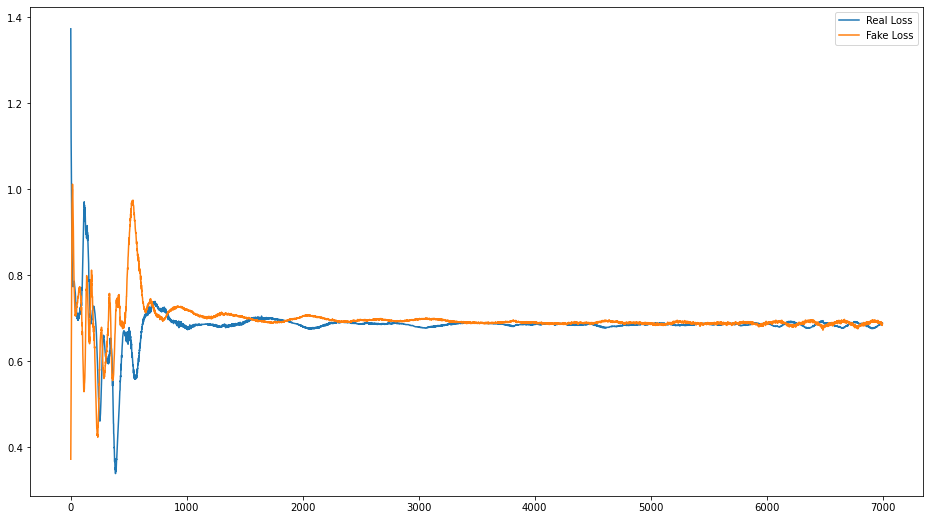

100%|██████████| 1000/1000 [01:01<00:00, 16.18it/s]


In [4]:
n_z = 100
n_cat_feats = 4
n_cont_feats = 4
n_targets = 1
len_ts = 24
n_samples = 1000
n_classes = 2
batch_size = 256
epochs = 1000

gan_type = 'bce'
model_type = 'cnn'

emb = EmbeddingModule([n_cat_feats])

structure = [n_z, 64, n_cont_feats]

if gan_type == 'wgan':
    n_gen = 1
    n_dis = 4
else:
    n_gen = 1
    n_dis = 1

if model_type == 'mlp':
    n_dim = 2
elif model_type == 'cnn':
    n_dim = 3

model = get_gan_model(gan_type=gan_type, model_type=model_type, structure=structure, len_ts=len_ts, n_classes=n_classes, emb_module=emb)
#data = DummyDataset(n_samples=n_samples, n_cat_feats=n_cat_feats, n_cont_feats=n_cont_feats, n_targets=n_targets, len_ts=len_ts, n_dim=n_dim)
data = SineDataset(n_samples=n_samples, n_classes=n_classes, n_features=n_cont_feats, noise=0)
dl = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
learner = GANLearner(gan=model, n_gen=n_gen, n_dis=n_dis)
learner.fit(dl, epochs=epochs, plot_epochs=epochs)

# Tests:

In [5]:
for x_cat, x_cont, y in dl:
    print(x_cat)
    break
x_fake = learner.generate_samples(x_cont).cpu()
x_fake, x_fake.shape

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1

(tensor([[[0.4289, 0.4905, 0.5537,  ..., 0.5362, 0.4709, 0.3807],
          [0.3458, 0.5438, 0.7079,  ..., 0.4593, 0.2464, 0.1061],
          [0.7867, 0.7903, 0.6500,  ..., 0.6396, 0.4111, 0.1976],
          [0.6184, 0.6845, 0.7302,  ..., 0.7036, 0.7589, 0.7832]],
 
         [[0.4483, 0.5064, 0.5746,  ..., 0.2495, 0.3029, 0.4187],
          [0.3653, 0.5651, 0.7318,  ..., 0.9401, 0.9348, 0.7302],
          [0.8146, 0.8183, 0.6806,  ..., 0.8852, 0.6554, 0.3774],
          [0.6422, 0.7118, 0.7568,  ..., 0.0181, 0.1902, 0.4517]],
 
         [[0.4178, 0.4816, 0.5416,  ..., 0.2489, 0.3020, 0.4104],
          [0.3410, 0.5341, 0.7068,  ..., 0.9342, 0.9297, 0.7263],
          [0.7782, 0.7691, 0.6405,  ..., 0.8817, 0.6512, 0.3699],
          [0.6076, 0.6721, 0.7098,  ..., 0.0188, 0.1929, 0.4531]],
 
         ...,
 
         [[0.2649, 0.3592, 0.4838,  ..., 0.4374, 0.3867, 0.3552],
          [0.4520, 0.7399, 0.9151,  ..., 0.3550, 0.1995, 0.1028],
          [0.9349, 0.7972, 0.5412,  ..., 0.5360, 0.

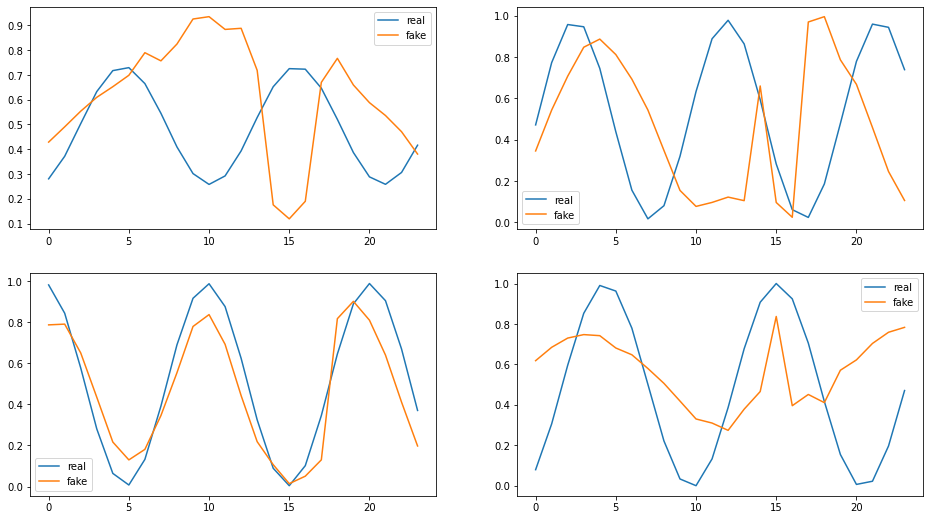

In [6]:
if n_dim == 3:
    plt.figure(figsize=(16, 9))
    for f in range(n_cont_feats):
        plt.subplot(2, 2, f+1)
        plt.plot(x_cont[0, f, :], label='real')
        plt.plot(x_fake[0, f, :], label='fake')
        plt.legend()
    plt.show()